# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime

import pandas as pd
from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 02/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig2b_'

In [3]:


birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'



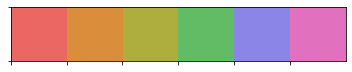

In [4]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [5]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")
axis_label_fontsize = 24

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [6]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Read in files

## Load formatted scores

In [7]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [8]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [9]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Make table of % of each stage per bin

In [10]:
binSize_min = 60
binSize_s = int(binSize_min*60)
binSize_ep = int(binSize_s/epochLength)

stageProportions_whole_night_all = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]
    
    nBins = 24 
    
    xlim_min= 0 
    xlim_max = xlim_min + 24
                
    # for Zeitgeber times falling before the desired Xmin, wrap around to next day by adding 24hrs
    too_early_inds = np.where(Scores['Zeitgeber time (h)'] < xlim_min)
    new_Zeit_hrs = Scores['Zeitgeber time (h)'].iloc[too_early_inds] + 24
    Scores['Zeitgeber time (h)'].iloc[too_early_inds] = new_Zeit_hrs.values
    
    startDatetime = np.datetime64(Scores.index.values[0])

    stageProportions = DataFrame([], columns=range(len(stages)))
    for bn in range(nBins):

        start = xlim_min +  bn   * binSize_min/60
        end   = xlim_min + (bn+1)* binSize_min/60

        bn_scores = Scores[(Scores['Zeitgeber time (h)']>=start)&(Scores['Zeitgeber time (h)']<end)]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)
                
        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Check that the proportions add up to 1.
    # In Bird 3, Zeitgeber hour ~2 wasn't scored due to camera going out of focus - mark proportions as NaN
    rowsums = np.round(np.sum(stageProportions[np.arange(-1,6)], axis=1), decimals=1)

    if any(rowsums < 1):
            bad_rows = np.where(rowsums < 1)[0]
            stageProportions.iloc[bad_rows] = np.nan
    
    # Calc TST and sleep stages as % TST
    
    stageProportions['TST'] = stageProportions[[2,3,4,5]].sum(axis=1)

    stageProportions['U (% TST)'] = stageProportions[2]/stageProportions['TST']
    stageProportions['I (% TST)'] = stageProportions[3]/stageProportions['TST']
    stageProportions['S (% TST)'] = stageProportions[4]/stageProportions['TST']
    stageProportions['R (% TST)'] = stageProportions[5]/stageProportions['TST']

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## save individual by-hour counts to csv

In [11]:
if saveData:
    for b in range(nBirds):
        stageProportions = stageProportions_whole_night_all[b]
        stageProportions.to_csv(saveAsPath + saveAsName + 'sleep_stages_by_hour_Bird' + str(b+1) + '.csv')

## Plot individual by-hour traces

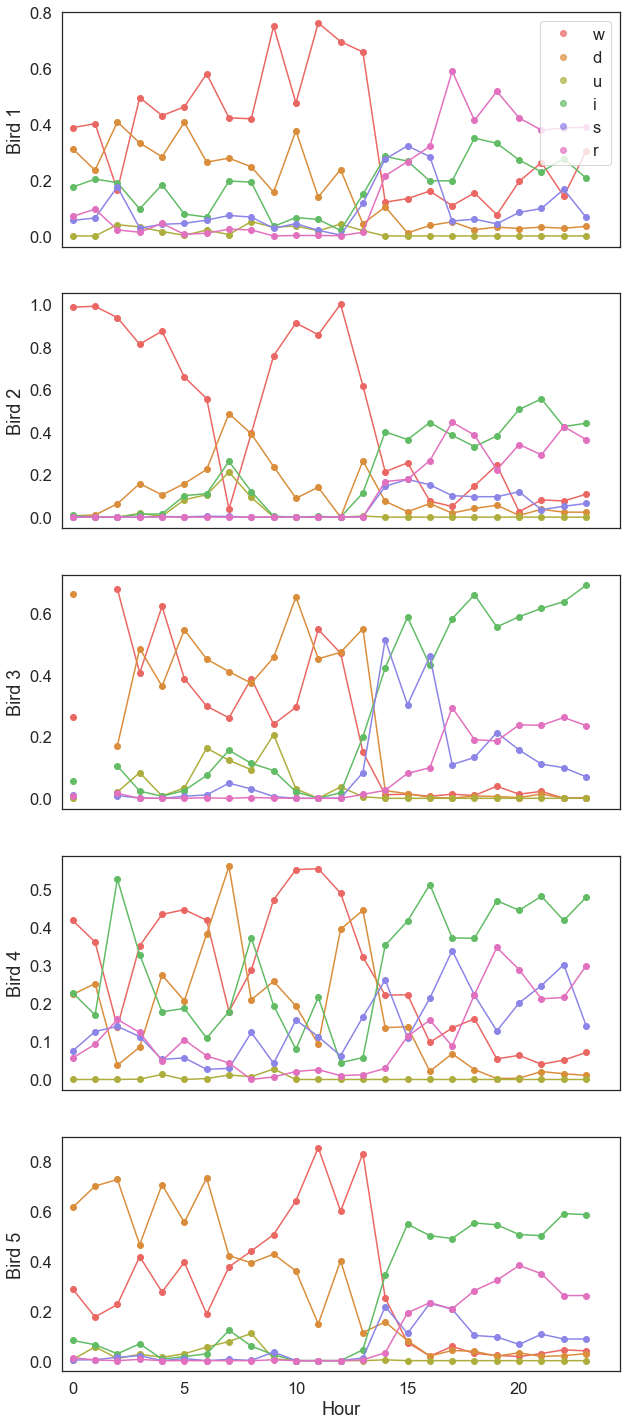

In [12]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_whole_night_all[b]
    
    # Plot
    with sns.color_palette(colors):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[0,1,2,3,4,5]], 'o-')
        
    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)+.5))
        
    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG, stages, loc=1)
        
    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xlabel('Hour')
        
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "All_birds_by_hour.pdf")

### By hour: % TST

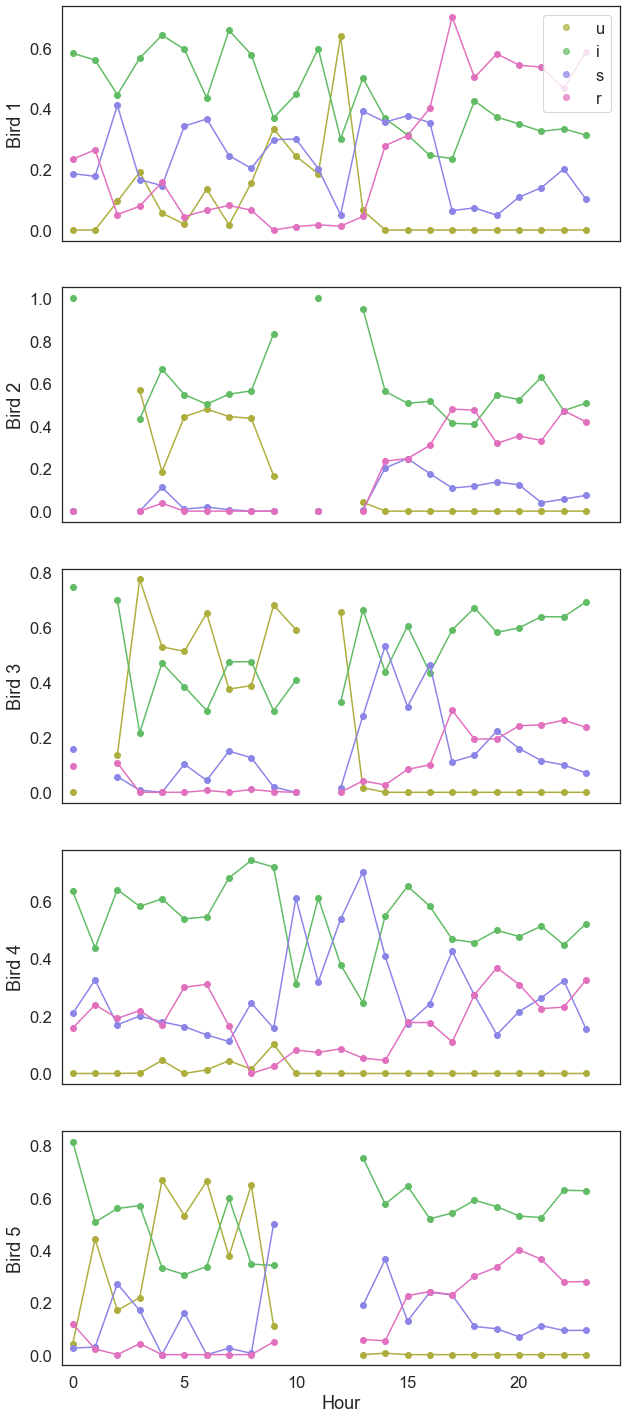

In [13]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):

    stageProportions = stageProportions_whole_night_all[b]

    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)']], 'o-')

    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)+.5))

    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)

    # X-axis labels just on last graph
    if b < nBirds-1:
        plt.xticks([])
    else:
        plt.xlabel('Hour')
        
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "All_birds_by_percent_of_TST.pdf")

### By hour of sleep

In [14]:
stageProportions_sleep_only = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    Scores = AllScores[b_name]

    Scores_Nighttime = Scores[int(lightsOffEp[b]):int(lightsOnEp[b])]

    Scores_Nighttime_Sleep = Scores_Nighttime[Scores_Nighttime['Label (#)']>=2]

    # Re-index to consecutive numbers starting at 0
    Scores_Nighttime_Sleep = Scores_Nighttime_Sleep.reset_index(drop=True)

    nBins_sleep = int(np.ceil(len(Scores_Nighttime_Sleep)/(binSize_ep)))

    stageProportions = DataFrame([], columns=np.arange(2,6))

    for bn in range(nBins_sleep):

        start_ep = int(bn*binSize_ep)
        end_ep   = int((bn+1)*binSize_ep)

        bn_scores = Scores_Nighttime_Sleep[start_ep:end_ep]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(normalize=True,sort=False)

        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)

    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)
    
    # Add to dictionary
    stageProportions_sleep_only[b] = stageProportions

Plot

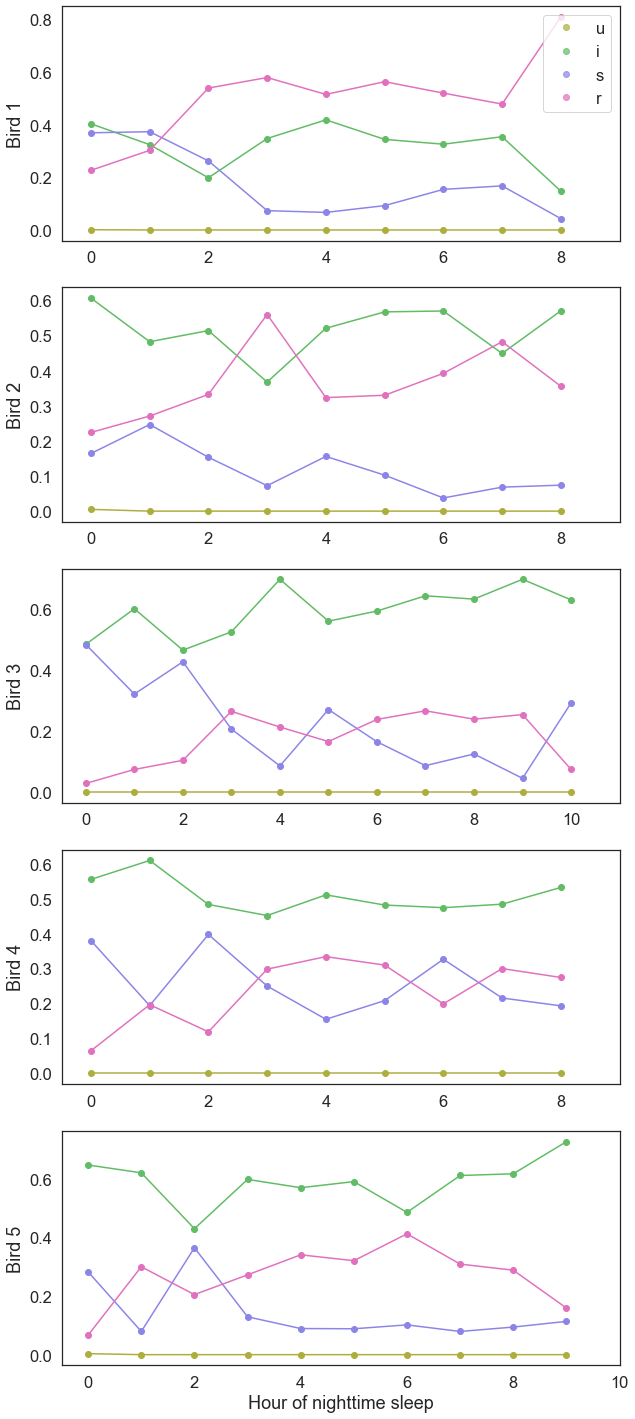

In [15]:
plt.figure(figsize=(10,5*nBirds))

for b in range(nBirds):
    stageProportions = stageProportions_sleep_only[b]
    
    # Plot
    with sns.color_palette(colors[2:6]):
        plt.subplot(nBirds,1,b+1)
        plt.plot(stageProportions[[2,3,4,5]], 'o-')
        
    # Labels etc
    plt.ylabel('Bird ' + str(b+1))
    plt.xlim((-0.5, len(stageProportions)))
        
    # Legend just on first graph
    if b == 0:
        plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)
        
    # X-axis labels just on last graph
    if b == nBirds-1:
        plt.xlabel('Hour of nighttime sleep')
        
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "All_birds_by_hour_of_sleep.pdf")

# Plot summary figures

Organize proportions by stage (instead of by bird)

In [16]:
stageProportions_by_stage = {}

stage_labels_by_hour = stageProportions_whole_night_all[0].columns.values

for st in stage_labels_by_hour:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_whole_night_all[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[st] = stageProportions_stage

In [17]:
stage_labels_by_sleep = stageProportions_sleep_only[0].columns.values

for st in stage_labels_by_sleep:
    stageProportions_stage = DataFrame([])
    
    for b in range(nBirds):
        stageProportions_bird = stageProportions_sleep_only[b]
        stageProportions_stage['Bird ' + str(b+1)] = stageProportions_bird[st]
        
    stageProportions_by_stage[str(st) + ' by hr of sleep'] = stageProportions_stage

## Find means and SDs per hour

In [18]:
nObservations = np.sum((np.isnan(stageProportions_by_stage[0]))==0, axis=1)

Means = DataFrame([])
SDs = DataFrame([])
SEMs = DataFrame([])

for st in stage_labels_by_hour:
    tmp_mean = stageProportions_by_stage[st].mean(axis=1)
    tmp_sd = stageProportions_by_stage[st].std(axis=1)
    nObservations = np.sum((np.isnan(stageProportions_by_stage[st]))==0, axis=1)
    tmp_sem = tmp_sd/np.sqrt(nObservations)
    
    Means[st] = tmp_mean
    SDs[st] = tmp_sd
    SEMs[st] = tmp_sem
    

In [19]:
for st in stage_labels_by_sleep:
    tmp_mean = stageProportions_by_stage[str(st) + ' by hr of sleep'].mean(axis=1,skipna=True)
    tmp_sd = stageProportions_by_stage[str(st) + ' by hr of sleep'].std(axis=1,skipna=True)
    
    Means[str(st) + ' by hr of sleep'] = tmp_mean
    SDs[str(st) + ' by hr of sleep'] = tmp_sd

##  FIGURE 2B: Plot by hour of night: all stages

### Just the legend

In [20]:
stage_names = ['Wake','Drowsy','Unihem','IS','SWS','REM']


# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o',
                                       markersize=10, lw=5, alpha=0.7))

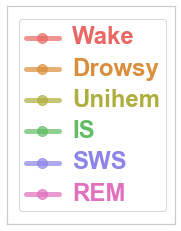

In [21]:
axis_color = [.8,.8,.8]
with plt.rc_context({'axes.edgecolor': axis_color}):  # set color of plot outline

    plt.figure(figsize=(3,4))
    leg = plt.legend(legendMarkersEEG, stage_names, loc=5)
    for text,st in zip(leg.get_texts(),range(len(stages))):
        plt.setp(text, color = colors[st], fontsize=24, fontweight='bold')

    plt.xticks([])
    plt.yticks([])

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "Legend.pdf")

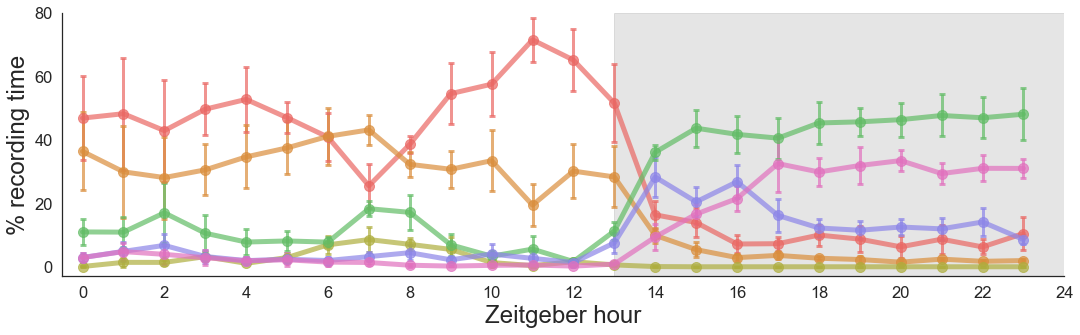

In [22]:
(100*Means[[0,1,2,3,4,5]]).plot(yerr=100*SEMs, # use SEM
                                color=colors, figsize=(15.35,5), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

# shade night in gray
plt.axvspan(13,24, color='k', alpha=0.1)

plt.xlabel('Zeitgeber hour',fontsize=axis_label_fontsize )
plt.ylabel('% recording time',fontsize=axis_label_fontsize )
plt.xlim((-.5, nBins - .5))
plt.xticks(np.arange(0,25,2))
plt.ylim((-3,80))
sns.despine()
plt.tight_layout()

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "Summary_by_hour_all24hr.pdf")

## Plot by hour of night: sleep only (%TST)

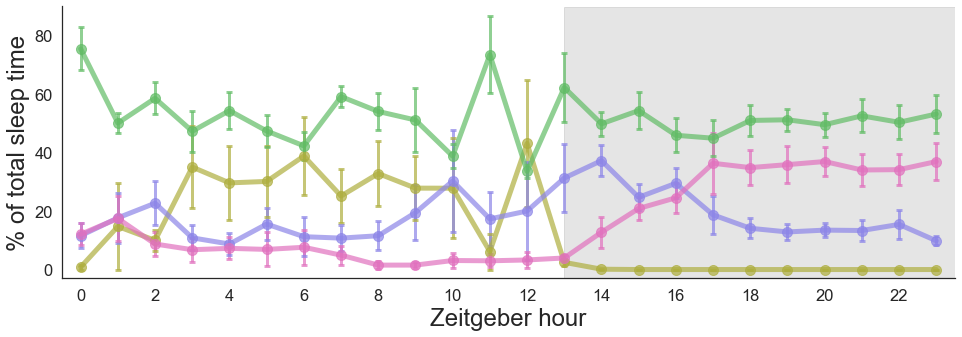

In [23]:
(100*Means[['U (% TST)', 'I (% TST)', 'S (% TST)', 'R (% TST)',]]).plot(yerr=100*SEMs, 
                                color=colors[2:6], figsize=(16,5), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

#plt.legend(legendMarkersEEG[2:6], stage_names[2:6], loc=1)

# shade night in gray
plt.axvspan(13,24, color='k', alpha=0.1)

plt.xlabel('Zeitgeber hour', fontsize=axis_label_fontsize)
plt.ylabel('% of total sleep time', fontsize=axis_label_fontsize)
plt.xlim((-.5, nBins - .5))
plt.xticks(np.arange(0,24,2), np.arange(0,24,2))
plt.ylim((-3,90))
sns.despine()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "Summary_by_percent_of_TST_all24hr.pdf")

## Plot by hour of sleep

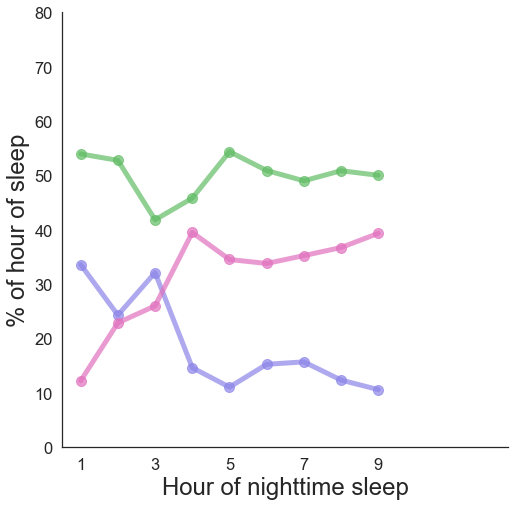

In [24]:
(100*Means[['3 by hr of sleep', '4 by hr of sleep', '5 by hr of sleep']]).plot(
                                yerr=100*SEMs, 
                                color=colors[3:6], figsize=(8,8), 
                                marker='o', markersize=10,
                                linewidth=5, alpha=0.7,
                                capsize=3, capthick=3,
                                elinewidth=3, legend='')

#plt.legend(legendMarkersEEG[2:6], stages[2:6], loc=1)

plt.xlabel('Hour of nighttime sleep', fontsize=axis_label_fontsize)
plt.ylabel('% of hour of sleep', fontsize=axis_label_fontsize)
plt.xlim((-.5, nBins/2 - .5))
plt.xticks(np.arange(0,9,2), np.arange(1,10,2))
plt.ylim((0,80))
sns.despine()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "Summary_by_hour_of_sleep.pdf")

## Save by-hour means and SDs to csv

In [25]:
Means.to_csv(saveAsPath + saveAsName + 'sleep_stages_by_hour_Means.csv')
SDs.to_csv(saveAsPath + saveAsName + 'sleep_stages_by_hour_SDs.csv')